In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
path_dataset = "../data/EVChargingStationUsage.csv"
data = pd.read_csv(path_dataset)

C:\Users\Mathias Dyhr\AppData\Local\Temp\ipykernel_11316\950735941.py:2: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path_dataset)


#### Exploratory Component:
What variables effect the probability that EV customers would hoard charging stations(i.e. charging the car longer than necessary)?

## Introduction

The efficiency of EV charging stations still have challenges. One of these challenges are hoarding behaviour, where users occupy the charging stations longer than necessary. This can lead to less useable charging stations and can negatively influence customer satisfaction and station utilization. With this analysis, we aim to look at the factors affecting the likelihood of hoarding behaviours among EV users. 

## Pre-Processing
First we need to find relevant data that can be used to answer the research question. Then it needs to be cleaned and structured so it is ready for analysis. 
- Most important is the duration of the charge to spot out the hoarders. (Start Date - End Date).
- Then we clean the data - create a column that indates weekday or weekend.
- Reduce data to only relevant features

In [ ]:
# Convert time to datetime format
data['Start Date'] = pd.to_datetime(data['Start Date'], errors='coerce')
data['End Date'] = pd.to_datetime(data['End Date'], errors='coerce')
# Invalid dates becomes NaT


# Remove the NaT time data 
data = data.dropna(subset=['Start Date', 'End Date'])

# Switch time format to hours
def duration_to_hours(duration_str):
    try:
        h, m, s = map(int, duration_str.split(':'))
        return h + m / 60 + s / 3600
    except ValueError:
        return None
data['Charging Duration (hrs)'] = data['Charging Time (hh:mm:ss)'].apply(duration_to_hours)

# Create a new column that indicates weekend
data['Day of Week'] = data['Start Date'].dt.dayofweek  # 0=Monday, 6=Sunday
data['Is Weekend'] = data['Day of Week'].apply(lambda x: 1 if x >= 5 else 0)  # 1=Weekend, 0=Weekday

# Only use relevant data points
relevant_columns = [
    'Station Name', 'City', 'Fee', 'Charging Duration (hrs)', 
    'Energy (kWh)', 'GHG Savings (kg)', 'Plug Type', 
    'Is Weekend', 'Latitude', 'Longitude', 'User ID'
]
used_data = data[relevant_columns]

## Pre-Visualization 

To identify the hoarding problem, we start by getting some visuals.

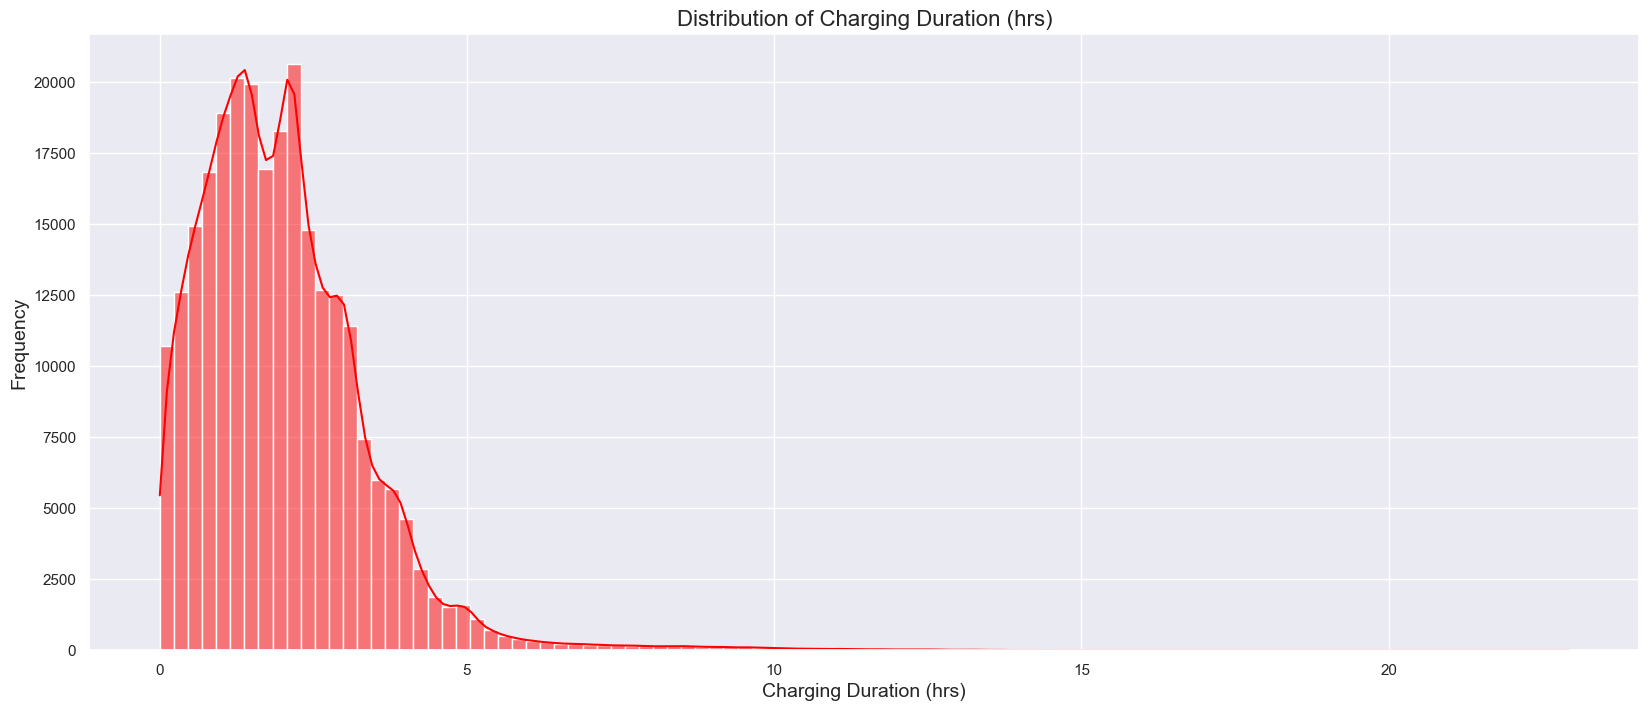

In [4]:
sns.set(style="darkgrid")
plt.figure(figsize=(20, 8))
sns.histplot(used_data['Charging Duration (hrs)'], bins=100, kde=True, color='red')
plt.title('Distribution of Charging Duration (hrs)', fontsize=16)
plt.xlabel('Charging Duration (hrs)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

It is seen that the EV charging stations are used at most between 0-3 hours. There is also a few people using it all the way to 5 hours.
Now we see the difference of energy consumptions for weekdays vs weekends.

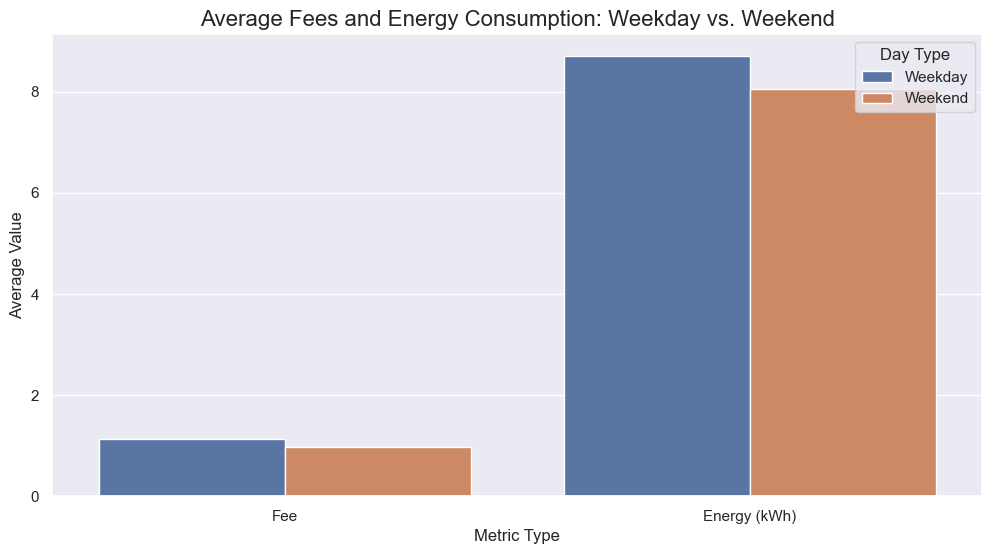

In [6]:
plt.figure(figsize=(12, 6))
weekend = used_data.groupby('Is Weekend')[['Fee', 'Energy (kWh)']].mean().reset_index()
weekend['Is Weekend'] = weekend['Is Weekend'].map({0: 'Weekday', 1: 'Weekend'})
weekend = weekend.melt(id_vars=['Is Weekend'], value_vars=['Fee', 'Energy (kWh)'], 
                               var_name='Metric', value_name='Average Value')
sns.barplot(data=weekend, x='Metric', y='Average Value', hue='Is Weekend', palette='deep')
plt.title('Average Fees and Energy Consumption: Weekday vs. Weekend', fontsize=16)
plt.xlabel('Metric Type', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.legend(title='Day Type', loc='upper right')
plt.show()

This plot shows us that the fee during weekday is higher but there are still more users charging during weekdays(This can be due to work and mandatory duties that are mostly carried out during weekdays). Nothing significant can be concluded from the plot.
To top it off, we perform a correlation matrix to see which selected features correlates best with each other.

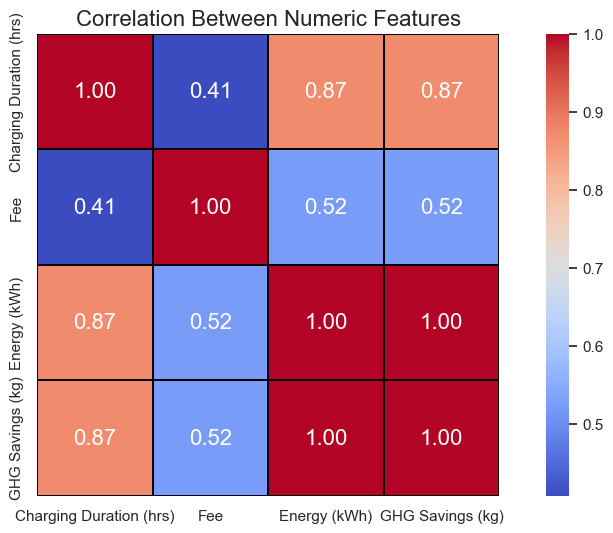

In [9]:
plt.figure(figsize=(12, 6))
nc = ['Charging Duration (hrs)', 'Fee', 'Energy (kWh)', 'GHG Savings (kg)']
corrmatrix = used_data[nc].corr()
sns.heatmap(corrmatrix, annot=True, cmap='coolwarm', fmt='.2f',annot_kws={"size": 16}, linewidths=0.2,linecolor='black', square=True)
plt.title('Correlation Between Numeric Features', fontsize=16)
plt.show()

It can be seen that the correlation is positively correlated between all features, some more than others.

## Clustering   
To get more insight into the users behaviours, we perform clustering and group users on their charging behaviours.
### Goal:
The goal is to segment users into groups of either short-duration or long-duration charges - based on relevant features. 

We start performing elbow method on relevant data to determine number of clusters.

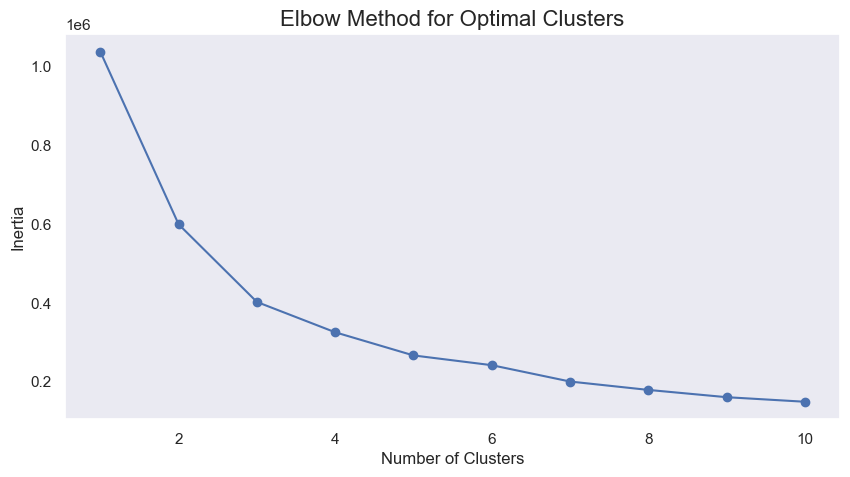

In [10]:
# Take relevant data
cluster_data = used_data[['Charging Duration (hrs)', 'Fee', 'Energy (kWh)', 'GHG Savings (kg)']].dropna()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

inertia = []
range_n_clusters = range(1, 11)
for k in range_n_clusters: #Elbow method
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.grid()
plt.show()

The elbow curve starts becoming less steep during k=3 

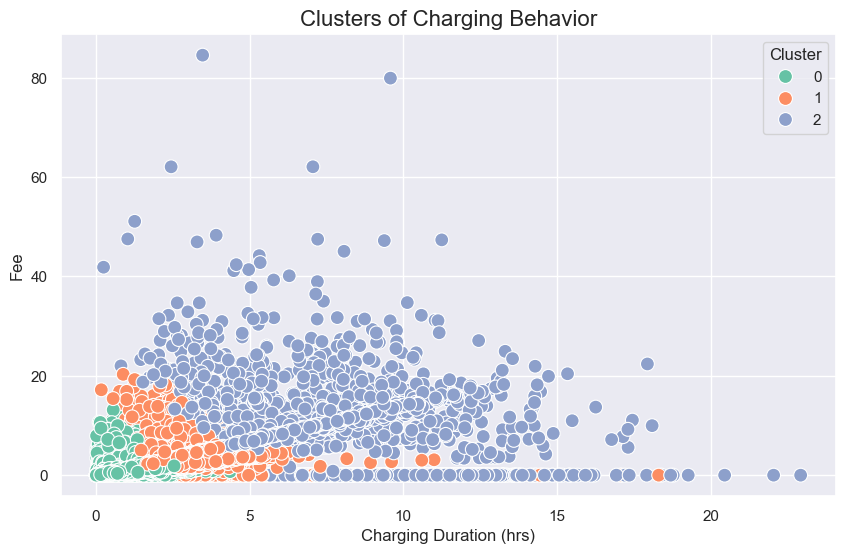

In [11]:
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_data['Cluster'] = kmeans.fit_predict(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=cluster_data,
    x='Charging Duration (hrs)',
    y='Fee',
    hue='Cluster',
    palette='Set2',
    s=100
)
plt.title('Clusters of Charging Behavior', fontsize=16)
plt.xlabel('Charging Duration (hrs)', fontsize=12)
plt.ylabel('Fee', fontsize=12)
plt.legend(title='Cluster')
plt.show()

In [10]:
cluster_summary = cluster_data.groupby('Cluster').agg({
    'Charging Duration (hrs)': 'mean',
    'Fee': 'mean',
    'Energy (kWh)': 'mean',
    'GHG Savings (kg)': 'mean'
}).reset_index()

print(cluster_summary)

   Cluster  Charging Duration (hrs)       Fee  Energy (kWh)  GHG Savings (kg)
0        0                 1.259438  0.546035      4.653914          1.954644
1        1                 3.010128  1.651855     13.535368          5.684855
2        2                 6.465808  7.054019     36.334559         15.260511


- Cluster 0(Green color) represents light users that charge briefly at low-cost stations with low energy consumption and GHG savings.
- Cluster 1(Orange color) represents moderate users who charge for a longer time, pays more and have higher GHG savings than cluster 0.
- Cluster 2(Blue color) represents heavy users who charge for long periods, pays a-lot more, consumes substantial energy and contribute the most to GHG savings.


To determine a hoarding threshold, we will look at the average duration of cluster 1 and cluster 2.

In [13]:
cluster_1_avg = 3.01 
cluster_2_avg = 6.47 
threshold = ((3.01 + 6.47 )/2)
print(threshold)

4.74


We conclude the threshold to be 4.74 hours - which means that everything above 4.74 hours becomes hoarding.

## Regression

Next step, we use a regression model to try and predict whether an EV user is likely to hoard a charging station.
- First we use the threshold 4.74 as our hoarding threshold
- Then determine predictor variables as features, and include the categorical feature(Plug Type) & encode into the features
- Next we split train/test and use RandomForestClassifier to predict
- Use of evaluation methods
- Visualize importance of features

C:\Users\Mathias Dyhr\AppData\Local\Temp\ipykernel_11316\1234857883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  used_data['Hoarding'] = (used_data['Charging Duration (hrs)'] > threshold).astype(int)
C:\Users\Mathias Dyhr\AppData\Local\Temp\ipykernel_11316\1234857883.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  used_data[cat_col] = label_encoder.fit_transform(used_data[cat_col])


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75307
           1       1.00      1.00      1.00      2506

    accuracy                           1.00     77813
   macro avg       1.00      1.00      1.00     77813
weighted avg       1.00      1.00      1.00     77813

Confusion Matrix:
[[75307     0]
 [    0  2506]]
Feature Importance:
Charging Duration (hrs)    0.502838
Energy (kWh)               0.221871
GHG Savings (kg)           0.209693
Fee                        0.055532
Latitude                   0.003922
Longitude                  0.003331
Plug Type                  0.002321
Is Weekend                 0.000493
dtype: float64


C:\Users\Mathias Dyhr\AppData\Local\Temp\ipykernel_11316\1234857883.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')


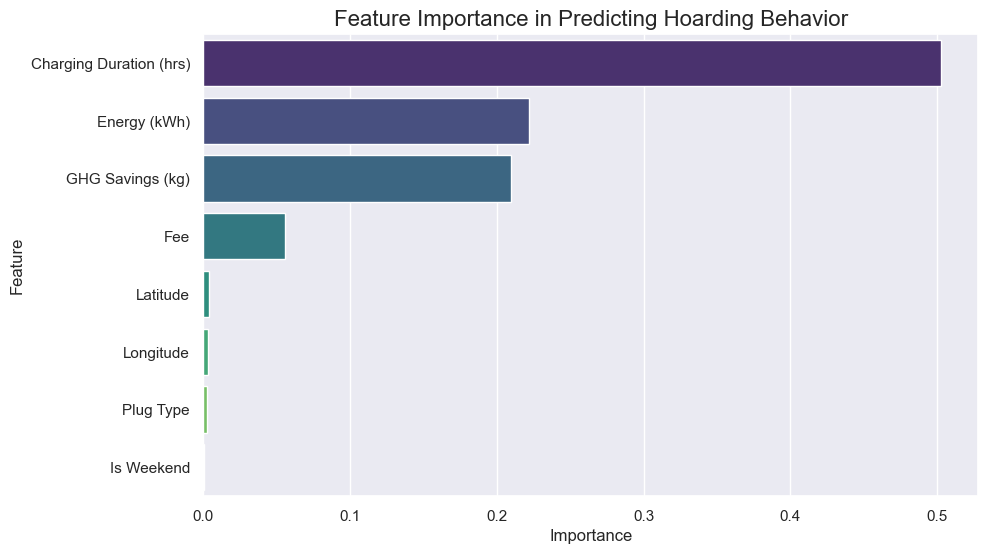

In [14]:
used_data['Hoarding'] = (used_data['Charging Duration (hrs)'] > threshold).astype(int)


features = ['Fee', 'Energy (kWh)', 'GHG Savings (kg)', 'Is Weekend', 'Latitude', 'Longitude','Charging Duration (hrs)']
categorical_features = ['Plug Type'] 
label_encoder = LabelEncoder()
for cat_col in categorical_features:
    used_data[cat_col] = label_encoder.fit_transform(used_data[cat_col])
    features.append(cat_col)

X = used_data[features]
y = used_data['Hoarding']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

feature_importance = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
print("Feature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')
plt.title('Feature Importance in Predicting Hoarding Behavior', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

With a 99% accuracy rate, the regression model performed admirably overall. However, because there is a large class gap—far more non-hoarders than hoarders—this high accuracy might be deceptive. The model is quite successful at properly detecting and categorizing non-hoarders (Class 0), as seen by the accuracy and recall of 0.99 for this group. With a precision of 0.82 and a recall of 0.73 for hoarders (Class 1), the model is less successful in detecting hoarders, missing 27% of instances.

With 75,307 non-hoarders and just 2,506 hoarders, the data distribution clearly shows a class imbalance. The macro-average metrics of precision (0.90), recall (0.86), and F1 score (0.88) are more indicative of overall performance across both classes as a result of this bias in the accuracy metric.

According to confusion matrix analysis, the model performs exceptionally well at accurately identifying non-hoarders (74,899 true negatives), while it has a harder time predicting hoarders (673 false negatives). Although the model works well for non-hoarders, there is room for improvement in terms of how well it can detect hoarders. (Decided not to go deeper into it since - it's not the research question)

By using the regression model predictions, we can apply targeted interventions like dynamic pricing. We can do this by adjusting fee for hoarding by any factor. In this case lets try and increase it by 1.2.

In [16]:
used_data['Adjusted Fee'] = used_data['Fee']
hoarding_mask = used_data['Hoarding'] == 1
used_data.loc[hoarding_mask, 'Adjusted Fee'] *= 1.2  #increase fee

C:\Users\Mathias Dyhr\AppData\Local\Temp\ipykernel_11316\3089315814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  used_data['Adjusted Fee'] = used_data['Fee']


With this, we can look over the entire timeline of the dataset, and see the difference in revenue that EV charging stations could have made, with the adjustment of fee for hoarders.

In [17]:
original_revenue = used_data['Fee'].sum()
adjusted_revenue = used_data['Adjusted Fee'].sum()
revenue_difference = adjusted_revenue - original_revenue

print(f"Original Revenue: ${original_revenue:.2f}")
print(f"Adjusted Revenue: ${adjusted_revenue:.2f}")
print(f"Revenue Difference: ${revenue_difference:.2f}")

Original Revenue: $284669.84
Adjusted Revenue: $292381.54
Revenue Difference: $7711.70


This means that a total of $7711.70 could have been made with this change.

WRITE THIS IN CONCLUSION:
-Discourage excessive charging durations.
-Increase revenue from those who do hoard.


In [16]:
# AI - GENERATED ANSWER (NEED CHANGE)
# Conclusions from the Regression Model:
#1. Overall Performance
#Accuracy: The model achieved an overall accuracy of 99%, which is excellent, but this may be misleading due to class imbalance (many more non-hoarders than hoarders).
#Precision (0 and 1):
#For Class 0 (non-hoarders), precision is 0.99, meaning the model rarely predicts hoarding when it's actually non-hoarding.
#For Class 1 (hoarders), precision is 0.82, meaning that 82% of the instances predicted as hoarding are correct.
#Recall (0 and 1):
#For Class 0, recall is 0.99, meaning almost all non-hoarders are correctly identified.
#For Class 1, recall is 0.73, meaning the model identifies 73% of hoarders but misses 27%.
#2. Class Imbalance Impact
#The support for Class 0 (non-hoarders) is 75,307, while for Class 1 (hoarders) it is only 2,506. This imbalance skews the accuracy, making it appear very high overall. The macro average metrics (precision: 0.90, recall: 0.86, F1: 0.88) provide a better picture of model performance across both classes.
#3. Confusion Matrix Analysis
#True Negatives (74,899): Non-hoarders correctly predicted as non-hoarders.
#False Positives (408): Non-hoarders incorrectly predicted as hoarders.
#True Positives (1,833): Hoarders correctly predicted as hoarders.
#False Negatives (673): Hoarders incorrectly predicted as non-hoarders.
#The model is highly accurate for non-hoarders but struggles more with hoarders (false negatives: 673). This indicates room for improvement in identifying hoarders.

#4. Feature Importance
#Key Predictors:
#Energy (kWh): The most important feature, contributing 42.68% to the predictions. This makes sense, as higher energy usage likely correlates with longer charging durations.
#GHG Savings (kg): The second most important feature (36.85%), as it is also closely tied to energy usage.
#Fee: Contributes 12.53%, indicating that higher fees may reflect longer charging sessions.
#Less Impactful Features:
#Latitude (3.47%) and Longitude (3.04%) suggest geographic location has minimal impact.
#Plug Type (0.76%) and Is Weekend (0.67%) have very low importance, meaning they don’t significantly influence predictions.
#Insights:
#Strong Predictors: Energy usage and GHG savings are the dominant predictors of hoarding behavior.
#Weakness in Identifying Hoarders: The recall for hoarders is 73%, so 27% of hoarders are missed. This may require additional focus to improve the model's sensitivity for this minority class.
#Feature Optimization: Plug Type and Is Weekend may not be as relevant. Consider revisiting their inclusion or engineering new features that better capture charging behavior.